In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from core.problem import ElementwiseProblem
from algorithms.moo.nsga2 import NSGA2
from constraints.as_obj import ConstraintsAsObjective
# from constraints.as_obj import ModifiedConstraintsAsObjective
from constraints.from_bounds import ConstraintsFromBounds
from constraints.as_penalty import ConstraintsAsPenalty
from gradient.automatic import MyAutomaticDifferentiation
from operators.survival.rank_and_crowding.classes import RankAndCrowding
from optimize import minimize
from visualization.scatter import Scatter

from pymoo.core.survival import Survival
from pymoo.operators.survival.rank_and_crowding.metrics import (
    calc_crowding_distance,
    get_crowding_function,
)
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from pymoo.problems import get_problem
from pymoo.util.plotting import plot

In [3]:
class ConstraintAsObjectiveSurvival(Survival):
    def __init__(self, nds=None, crowding_func="cd"):
        """
        A generalization of the NSGA-II survival operator that ranks individuals by dominance criteria
        and sorts the last front by some user-specified crowding metric. The default is NSGA-II's crowding distances
        although others might be more effective.

        For many-objective problems, try using 'mnn' or '2nn'.

        For Bi-objective problems, 'pcd' is very effective.

        Parameters
        ----------
        nds : str or None, optional
            Pymoo type of non-dominated sorting. Defaults to None.

        crowding_func : str or callable, optional
            Crowding metric. Options are:

                - 'cd': crowding distances
                - 'pcd' or 'pruning-cd': improved pruning based on crowding distances
                - 'ce': crowding entropy
                - 'mnn': M-Nearest Neighbors
                - '2nn': 2-Nearest Neighbors

            If callable, it has the form ``fun(F, filter_out_duplicates=None, n_remove=None, **kwargs)``
            in which F (n, m) and must return metrics in a (n,) array.

            The options 'pcd', 'cd', and 'ce' are recommended for two-objective problems, whereas 'mnn' and '2nn' for many objective.
            When using 'pcd', 'mnn', or '2nn', individuals are already eliminated in a 'single' manner.
            Due to Cython implementation, they are as fast as the corresponding 'cd', 'mnn-fast', or '2nn-fast',
            although they can singnificantly improve diversity of solutions.
            Defaults to 'cd'.
        """

        crowding_func_ = get_crowding_function(crowding_func)

        super().__init__(filter_infeasible=True)
        self.nds = nds if nds is not None else NonDominatedSorting()
        self.crowding_func = crowding_func_
        self.ranking = RankAndCrowding(nds=nds, crowding_func=crowding_func)

    def _do(self, problem, pop, n_survive, algorithm=None, **kwargs):
        # Extract objective values and constraint violation values
        F = pop.get("F").astype(float, copy=False)

        CV = F[:, -1]  # assuming CV is the last column in F
        true_objectives = F[:, :-1]  # all but the last column

        # Split population based on feasibility
        is_feasible = CV <= 0
        feasible = pop[is_feasible]
        infeasible = pop[np.logical_not(is_feasible)]

        # Perform non-dominated sorting and crowding distance calculation on feasible solutions
        if len(feasible) > 0:
            fronts = self.nds.do(
                true_objectives[is_feasible], n_stop_if_ranked=n_survive
            )
            feasible = self.sort_by_fronts(
                feasible, true_objectives[is_feasible], fronts, n_survive
            )

        # Directly sort infeasible solutions by their constraint violation in ascending order
        if len(infeasible) > 0:
            infeasible_indices = np.argsort(CV[np.logical_not(is_feasible)])
            infeasible = infeasible[infeasible_indices[: n_survive - len(feasible)]]

        # Merge feasible and infeasible solutions based on their ranking and constraint handling
        survivors = pop.create(np.concatenate([feasible, infeasible]))
        return survivors

    def sort_by_fronts(self, pop, objectives, fronts, n_survive):
        survivors = []
        for front in fronts:
            if len(survivors) + len(front) > n_survive:
                # Calculate crowding distance within the front
                distances = calc_crowding_distance(objectives[front])
                # Choose the best based on crowding distance
                selected = np.argsort(-distances)[: n_survive - len(survivors)]
                survivors.extend(pop[front][selected])
                break
            survivors.extend(pop[front])
        return survivors

    def _do(self, problem, pop, *args, n_survive=None, **kwargs):

        if n_survive is None:
            n_survive = len(pop)

        n_survive = min(n_survive, len(pop))

        # If the split should be done beforehand
        if problem.n_constr > 0:

            # Split by feasibility
            feas, infeas = split_by_feasibility(
                pop, sort_infeas_by_cv=True, sort_feas_by_obj=False, return_pop=False
            )

            # Obtain len of feasible
            n_feas = len(feas)

            # Assure there is at least_one survivor
            if n_feas == 0:
                survivors = Population()
            else:
                survivors = self.ranking.do(
                    problem,
                    pop[feas],
                    *args,
                    n_survive=min(len(feas), n_survive),
                    **kwargs
                )

            # Calculate how many individuals are still remaining to be filled up with infeasible ones
            n_remaining = n_survive - len(survivors)

            # If infeasible solutions need to be added
            if n_remaining > 0:

                # Constraints to new ranking
                G = pop[infeas].get("G")
                G = np.maximum(G, 0)
                H = pop[infeas].get("H")
                H = np.absolute(H)
                C = np.column_stack((G, H))

                # Fronts in infeasible population
                infeas_fronts = self.nds.do(C, n_stop_if_ranked=n_remaining)

                # Iterate over fronts
                for k, front in enumerate(infeas_fronts):

                    # Save ranks
                    pop[infeas][front].set("cv_rank", k)

                    # Current front sorted by CV
                    if len(survivors) + len(front) > n_survive:

                        # Obtain CV of front
                        CV = pop[infeas][front].get("CV").flatten()
                        I = randomized_argsort(CV, order="ascending", method="numpy")
                        I = I[: (n_survive - len(survivors))]

                    # Otherwise take the whole front unsorted
                    else:
                        I = np.arange(len(front))

                    # extend the survivors by all or selected individuals
                    survivors = Population.merge(survivors, pop[infeas][front[I]])

        else:
            survivors = self.ranking.do(
                problem, pop, *args, n_survive=n_survive, **kwargs
            )

        return survivors

In [3]:
algorithm = NSGA2(
    pop_size=100,
    # pcd, mnn, 2nn implementation are in Cython (cannot run directly on Jupyter notebook)
    survival=RankAndCrowding()
)

# algorithm2 = NSGA2(
#     pop_size=100,
# pcd, mnn, 2nn implementation are in Cython (cannot run directly on Jupyter notebook)
#     survival=ConstraintAsObjectiveSurvival()
# )

In [4]:
import time


def performance_timer(func):
    """
    A decorator to measure and print the execution time of a function.
    """
    def wrapper(*args, **kwargs):
        start_time = time.time()  # Capture the start time
        result = func(*args, **kwargs)  # Execute the function
        end_time = time.time()  # Capture the end time
        duration = end_time - start_time  # Calculate duration
        print(f"{func.__name__} executed in {duration:.6f} seconds")
        return result
    return wrapper


@performance_timer
def minimize_(*args, **kwargs):
    return minimize(*args, **kwargs)

In [5]:
from constraints.as_obj import CVRAsObjective, WCVFAsObjective


@performance_timer
def compare_on(problem, n_gen=300):
    res0 = minimize_(problem,
                     algorithm,
                     ('n_gen', n_gen),
                     seed=1,
                     verbose=False)

    res1 = minimize_(ConstraintsAsObjective(problem),
                     algorithm,
                     ('n_gen', n_gen),
                     seed=1,
                     verbose=False)

    res2 = minimize_(CVRAsObjective(problem),
                     algorithm,
                     ('n_gen', n_gen),
                     seed=1,
                     verbose=False)

    res3 = minimize_(WCVFAsObjective(problem),
                     algorithm,
                     ('n_gen', n_gen),
                     seed=1,
                     verbose=False)

    # res2 = minimize_(ConstraintsAsObjective(problem, config=dict(
    #     cache=True,
    #     cv_eps=0.0,
    #     cv_ieq=dict(scale=None, eps=0.0, pow=None, func=np.max),
    #     cv_eq=dict(scale=None, eps=1e-4, pow=None, func=np.max),
    # )),
    #     algorithm,
    #     ('n_gen', n_gen),
    #     seed=1,
    #     verbose=False)

    # res3 = minimize_(CVRAsObjective(problem, config=dict(
    #     cache=True,
    #     cv_eps=0.0,
    #     cv_ieq=dict(scale=None, eps=0.0, pow=None, func=np.median),
    #     cv_eq=dict(scale=None, eps=1e-4, pow=None, func=np.median), # mean, sum of square, count of violation
    # )),
    #     algorithm,
    #     ('n_gen', n_gen),
    #     seed=1,
    #     verbose=False)

    return res0, res1, res2, res3

# Custom problem


In [6]:
class ConstrainedProblem(ElementwiseProblem):

    def __init__(self, **kwargs):
        super().__init__(n_var=2, n_obj=1, n_ieq_constr=1,
                         n_eq_constr=0, xl=0, xu=2, **kwargs)

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = x[0] ** 2 + x[1] ** 2
        out["G"] = 1.0 - (x[0] + x[1])

In [ ]:
problem = ConstrainedProblem()

res0, res1, res2, res3 = compare_on(problem)

plot = Scatter()
plot.add(problem.pareto_front(), marker="*",
         color="orange", label='Pareto front')
plot.add(res0.F, marker="x", color="red", label='Death penalty')
plot.add(res1.F[:, :-1], marker="+", color="green", label='Baseline CV_as_obj')
plot.add(res2.F[:, :-1], marker="1", color="blue", label='Our CV_as_obj')
plot.add(res3.F[:, :-1], marker="2", color="purple", label='Our CV_as_obj')
plot.show()

In [ ]:
# print(f'F1-F2: {sum(res1.F - res2.F)}   F2-F3{sum(res2.F - res3.F)}   F1-F3{sum(res1.F - res3.F)}')

In [ ]:
res1.F

In [ ]:
# from pymoo.core.evaluator import Evaluator
# from pymoo.core.individual import Individual

# cv = res1.F[:, 0]
# least_infeas = cv.argmin()
# x = res1.X[least_infeas]

# sol = Individual(X=x)
# Evaluator().eval(problem, sol)

# print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (sol.X, sol.F, sol.CV))

In [ ]:
# cv = res2.F[:, 0]
# least_infeas = cv.argmin()
# x = res2.X[least_infeas]

# sol = Individual(X=x)
# Evaluator().eval(problem, sol)

# print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (sol.X, sol.F, sol.CV))

# BNH


In [ ]:
problem_bnh = get_problem("bnh")
problem = problem_bnh
print(f'Problem {problem.name}: n_var={problem.n_var} n_obj={problem.n_obj} n_ieq_constr={problem.n_ieq_constr} n_eq_constr={problem.n_eq_constr}')

res0, res1, res2, res3 = compare_on(problem)
print(f'F1-F2: {sum(res1.F - res2.F)}   F2-F3{sum(res2.F - res3.F)}   F1-F3{sum(res1.F - res3.F)}')

plot = Scatter()
plot.add(problem.pareto_front(), marker="*",
         color="orange", label='Pareto front')
plot.add(res0.F, marker="x", color="red", label='Death penalty')
plot.add(res1.F[:, :-1], marker="+", color="green", label='Baseline CV_as_obj')
plot.add(res2.F[:, :-1], marker="1", color="blue", label='Our CV_as_obj')
plot.add(res3.F[:, :-1], marker="1", color="purple", label='Our CV_as_obj')
plot.show()

In [ ]:
plot = Scatter()
plot.add(problem.pareto_front(), marker="*",
         color="orange", label='Pareto front')
# plot.add(res0.F, marker="x", color="red", label='Death penalty')
# plot.add(res1.F[:, :-1], marker="+", color="green", label='Baseline CV_as_obj')
# plot.add(res2.F[:, :-1], marker="1", color="blue", label='Our CV_as_obj')
plot.add(res3.F[:, :-1], marker="1", color="purple", label='Our CV_as_obj')
plot.show()

# ZDT


In [ ]:
problem_zdt1 = get_problem("zdt1")
problem = problem_zdt1
print(f'Problem {problem.name}: n_var={problem.n_var} n_obj={problem.n_obj} n_ieq_constr={problem.n_ieq_constr} n_eq_constr={problem.n_eq_constr}')

res0, res1, res2, res3 = compare_on(problem)
print(f'F1-F2: {sum(res1.F - res2.F)}   F2-F3{sum(res2.F - res3.F)}   F1-F3{sum(res1.F - res3.F)}')

plot = Scatter()
plot.add(problem.pareto_front(), marker="*",
         color="orange", label='Pareto front')
plot.add(res0.F, marker="x", color="red", label='Death penalty')
plot.add(res1.F[:, :-1], marker="+", color="green", label='Baseline CV_as_obj')
plot.add(res2.F[:, :-1], marker="1", color="blue", label='Our CV_as_obj')
plot.add(res3.F[:, :-1], marker="1", color="purple", label='Our CV_as_obj')
plot.show()

In [ ]:
problem_zdt2 = get_problem("zdt2")

res0, res1, res2, res3 = compare_on(problem_zdt2)

plot = Scatter()
plot.add(problem_zdt2.pareto_front(), marker="*",
         color="orange", label='Pareto front')
plot.add(res0.F, marker="x", color="red", label='Death penalty')
plot.add(res1.F[:, :-1], marker="+", color="green", label='Baseline CV_as_obj')
plot.add(res2.F[:, :-1], marker="1", color="blue", label='Our CV_as_obj')
plot.add(res3.F[:, :-1], marker="1", color="purple", label='Our CV_as_obj')
plot.show()

In [ ]:
print(
    f"F1-F2: {sum(res1.F - res2.F)}   F2-F3{sum(res2.F - res3.F)}   F1-F3{sum(res1.F - res3.F)}"
)

In [ ]:
problem_zdt3 = get_problem("zdt3")

res0, res1, res2, res3 = compare_on(problem_zdt3)

plot = Scatter()
plot.add(problem_zdt3.pareto_front(), marker="*",
         color="orange", label='Pareto front')
plot.add(res0.F, marker="x", color="red", label='Death penalty')
plot.add(res1.F[:, :-1], marker="+", color="green", label='Baseline CV_as_obj')
plot.add(res2.F[:, :-1], marker="1", color="blue", label='Our CV_as_obj')
plot.add(res3.F[:, :-1], marker="1", color="purple", label='Our CV_as_obj')
plot.show()

In [ ]:
print(
    f"F1-F2: {sum(res1.F - res2.F)}   F2-F3{sum(res2.F - res3.F)}   F1-F3{sum(res1.F - res3.F)}"
)

In [ ]:
problem_zdt4 = get_problem("zdt4")

res0, res1, res2, res3 = compare_on(problem_zdt4)
print(f'F1-F2: {sum(res1.F - res2.F)}   F2-F3{sum(res2.F - res3.F)}   F1-F3{sum(res1.F - res3.F)}')

plot = Scatter()
plot.add(problem_zdt4.pareto_front(), marker="*",
         color="orange", label='Pareto front')
plot.add(res0.F, marker="x", color="red", label='Death penalty')
plot.add(res1.F[:, :-1], marker="+", color="green", label='Baseline CV_as_obj')
plot.add(res2.F[:, :-1], marker="1", color="blue", label='Our CV_as_obj')
plot.add(res3.F[:, :-1], marker="1", color="purple", label='Our CV_as_obj')
plot.show()

In [ ]:
plot = Scatter()
plot.add(res1.F, facecolor="none", edgecolor="green")
plot.add(res2.F, facecolor="none", edgecolor="blue")
plot.add(res3.F, facecolor="none", edgecolor="purple")
plot.show()

In [ ]:
problem_zdt5 = get_problem("zdt5", normalize=False)

res0, res1, res2, res3 = compare_on(problem_zdt5, n_gen=3000)
print(f'F1-F2: {sum(res1.F - res2.F)}   F2-F3{sum(res2.F - res3.F)}   F1-F3{sum(res1.F - res3.F)}')

plot = Scatter()
plot.add(problem_zdt5.pareto_front(), marker="*",
         color="orange", label='Pareto front')
plot.add(res0.F, marker="x", color="red", label='Death penalty')
plot.add(res1.F[:, :-1], marker="+", color="green", label='Baseline CV_as_obj')
plot.add(res2.F[:, :-1], marker="1", color="blue", label='Our CV_as_obj')
plot.add(res3.F[:, :-1], marker="1", color="purple", label='Our CV_as_obj')
plot.show()

In [ ]:
problem_zdt6 = get_problem("zdt6")

res0, res1, res2, res3 = compare_on(problem_zdt6)
print(f'F1-F2: {sum(res1.F - res2.F)}   F2-F3{sum(res2.F - res3.F)}   F1-F3{sum(res1.F - res3.F)}')

plot = Scatter()
plot.add(problem_zdt6.pareto_front(), marker="*",
         color="orange", label='Pareto front')
plot.add(res0.F, marker="x", color="red", label='Death penalty')
plot.add(res1.F[:, :-1], marker="+", color="green", label='Baseline CV_as_obj')
plot.add(res2.F[:, :-1], marker="1", color="blue", label='Our CV_as_obj')
plot.add(res3.F[:, :-1], marker="1", color="purple", label='Our CV_as_obj')
plot.show()

In [ ]:
# cv = res3.F[:, 0]
# least_infeas = cv.argmin()
# x = res3.X[least_infeas]

# sol = Individual(X=x)
# Evaluator().eval(problem2, sol)

# print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (sol.X, sol.F, sol.CV))

In [ ]:
# plot = Scatter()
# plot.add(problem2.pareto_front(), marker="*", color="black", alpha=0.7, s=100)
# plot.add(res3.F[:,1:], facecolor="none", edgecolor="red")
# plot.show()

In [ ]:
# X, F = res3.opt.get("X", "F")
# hist = res3.history
# print(len(hist))

In [ ]:
# n_evals = []             # corresponding number of function evaluations\
# hist_F = []              # the objective space values in each generation
# hist_cv = []             # constraint violation in each generation
# hist_cv_avg = []         # average constraint violation in the whole population

# for algo in hist:

#     # store the number of function evaluations
#     n_evals.append(algo.evaluator.n_eval)

#     # retrieve the optimum from the algorithm
#     opt = algo.opt

#     # store the least contraint violation and the average in each population
#     hist_cv.append(opt.get("CV").min())
#     hist_cv_avg.append(algo.pop.get("CV").mean())

#     # filter out only the feasible and append and objective space values
#     feas = np.where(opt.get("feasible"))[0]
#     hist_F.append(opt.get("F")[feas])

In [ ]:
# k = np.where(np.array(hist_cv) <= 0.0)[0].min()
# print(f"At least one feasible solution in Generation {k} after {n_evals[k]} evaluations.")

In [ ]:
# # replace this line by `hist_cv` if you like to analyze the least feasible optimal solution and not the population
# vals = hist_cv_avg

# k = np.where(np.array(vals) <= 0.0)[0].min()
# print(f"Whole population feasible in Generation {k} after {n_evals[k]} evaluations.")

# plt.figure(figsize=(7, 5))
# plt.plot(n_evals, vals,  color='black', lw=0.7, label="Avg. CV of Pop")
# plt.scatter(n_evals, vals,  facecolor="none", edgecolor='black', marker="p")
# plt.axvline(n_evals[k], color="red", label="All Feasible", linestyle="--")
# plt.title("Convergence")
# plt.xlabel("Function Evaluations")
# plt.ylabel("Hypervolume")
# plt.legend()
# plt.show()

In [ ]:
# approx_ideal = F[:,-2:].min(axis=0)
# approx_nadir = F[:,-2:].max(axis=0)
# approx_ideal, approx_nadir

In [ ]:
# from pymoo.indicators.hv import Hypervolume

# metric = Hypervolume(ref_point=np.array([0.1, 0.1]),
#                      norm_ref_point=False,
#                      zero_to_one=True,
#                      ideal=approx_ideal,
#                      nadir=approx_nadir)

# hv = [metric.do(_F[:, -2:]) for _F in hist_F]

# plt.figure(figsize=(7, 5))
# plt.plot(n_evals, hv, color='black', lw=0.7, label="Avg. CV of Pop")
# plt.scatter(n_evals, hv, facecolor="none", edgecolor='black', marker="p")
# plt.title("Convergence")
# plt.xlabel("Function Evaluations")
# plt.ylabel("Hypervolume")
# plt.show()

In [ ]:
# from pymoo.util.running_metric import RunningMetricAnimation

# running = RunningMetricAnimation(delta_gen=5,
#                         n_plots=3,
#                         key_press=False,
#                         do_show=True)

# for algorithm in res3.history[:50]:
#     running.update(algorithm)

In [ ]:
# from pymoo.indicators.igd import IGD

# metric = IGD(pf, zero_to_one=True)

# igd = [metric.do(_F) for _F in hist_F]

# plt.plot(n_evals, igd,  color='black', lw=0.7, label="Avg. CV of Pop")
# plt.scatter(n_evals, igd,  facecolor="none", edgecolor='black', marker="p")
# plt.axhline(10**-2, color="red", label="10^-2", linestyle="--")
# plt.title("Convergence")
# plt.xlabel("Function Evaluations")
# plt.ylabel("IGD")
# plt.yscale("log")
# plt.legend()
# plt.show()

# OSY


In [ ]:
problem_osy = get_problem("osy")
problem = problem_osy
print(f'Problem {problem.name}: n_var={problem.n_var} n_obj={problem.n_obj} n_ieq_constr={problem.n_ieq_constr} n_eq_constr={problem.n_eq_constr}')

res0, res1, res2, res3 = compare_on(problem)
print(f'F1-F2: {sum(res1.F - res2.F)}   F2-F3{sum(res2.F - res3.F)}   F1-F3{sum(res1.F - res3.F)}')

plot = Scatter()
plot.add(problem.pareto_front(), marker="*",
         color="orange", label='Pareto front')
plot.add(res0.F, marker="x", color="red", label='Death penalty')
plot.add(res1.F[:, :-1], marker="+", color="green", label='Baseline CV_as_obj')
plot.add(res2.F[:, :-1], marker="1", color="blue", label='Our CV_as_obj')
plot.add(res3.F[:, :-1], marker="1", color="purple", label='Our CV_as_obj')
plot.show()

In [ ]:
plot = Scatter()
plot.add(res1.F, facecolor="none", edgecolor="green")
plot.add(res2.F, facecolor="none", edgecolor="blue")
plot.add(res3.F, facecolor="none", edgecolor="purple")
plot.show()

In [ ]:
plt.hist(res1.F[:, -1:], bins=30, color='green',
         alpha=0.7, label='Sum CV_as_obj')
plt.hist(res2.F[:, -1:], bins=30, color='blue',
         alpha=0.7, label='Max CV_as_obj')
plt.hist(res3.F[:, -1:], bins=30, color='purple',
         alpha=0.7, label='Median CV_as_obj')

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of CV')

# Add a legend
plt.legend()

# Show the plot
plt.show()

# TNK


In [ ]:
problem_tnk = get_problem("tnk")
problem = problem_tnk
print(f'Problem {problem.name}: n_var={problem.n_var} n_obj={problem.n_obj} n_ieq_constr={problem.n_ieq_constr} n_eq_constr={problem.n_eq_constr}')

res0, res1, res2, res3 = compare_on(problem, n_gen=2000)
print(f'F1-F2: {sum(res1.F - res2.F)}   F2-F3{sum(res2.F - res3.F)}   F1-F3{sum(res1.F - res3.F)}')

plot = Scatter()
plot.add(problem.pareto_front(), marker="*",
         color="orange", label='Pareto front')
plot.add(res0.F, marker="x", color="red", label='Death penalty')
plot.add(res1.F[:, :-1], marker="+", color="green", label='Baseline CV_as_obj')
plot.add(res2.F[:, :-1], marker="1", color="blue", label='Our CV_as_obj')
plot.add(res3.F[:, :-1], marker="1", color="purple", label='Our CV_as_obj')
plot.show()

In [ ]:
plot = Scatter()
plot.add(res1.F, facecolor="none", edgecolor="green")
plot.add(res2.F, facecolor="none", edgecolor="blue")
plot.add(res3.F, facecolor="none", edgecolor="purple")
plot.show()

In [ ]:
plt.hist(res1.F[:, -1:], bins=30, color='green',
         alpha=0.7, label='Sum CV_as_obj')
plt.hist(res2.F[:, -1:], bins=30, color='blue',
         alpha=0.7, label='Max CV_as_obj')
plt.hist(res3.F[:, -1:], bins=30, color='purple',
         alpha=0.7, label='Median CV_as_obj')

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of CV')

# Add a legend
plt.legend()

# Show the plot
plt.show()

# Carside


In [ ]:
problem_carside = get_problem("Carside")
problem = problem_carside
print(f'Problem {problem.name}: n_var={problem.n_var} n_obj={problem.n_obj} n_ieq_constr={problem.n_ieq_constr} n_eq_constr={problem.n_eq_constr}')

res0, res1, res2, res3 = compare_on(problem, n_gen=2000)
print(f'F1-F2: {sum(res1.F - res2.F)}   F2-F3{sum(res2.F - res3.F)}   F1-F3{sum(res1.F - res3.F)}')

plot = Scatter()
plot.add(problem.pareto_front(), marker="*",
         color="orange", label='Pareto front')
plot.add(res0.F, marker="x", color="red", label='Death penalty')
plot.add(res1.F[:, :-1], marker="+", color="green", label='Baseline CV_as_obj')
plot.add(res2.F[:, :-1], marker="1", color="blue", label='Our CV_as_obj')
plot.add(res3.F[:, :-1], marker="1", color="purple", label='Our CV_as_obj')
plot.show()

In [ ]:
res2.F[:, -1]

# Pressure Vessel

In [ ]:
problem_carside = get_problem("pressure_vessel")
problem = problem_carside
print(f'Problem {problem.name}: n_var={problem.n_var} n_obj={problem.n_obj} n_ieq_constr={problem.n_ieq_constr} n_eq_constr={problem.n_eq_constr}')

res0, res1, res2, res3 = compare_on(problem, n_gen=500)
# print(f'F1-F2: {sum(res1.F - res2.F)}   F2-F3{sum(res2.F - res3.F)}   F1-F3{sum(res1.F - res3.F)}')

plot = Scatter()
plot.add(problem.pareto_front(), marker="*",
         color="orange", label='Pareto front')
plot.add(res0.F, marker="x", color="red", label='Death penalty')
plot.add(res1.F[:, :-1], marker="+", color="green", label='Baseline CV_as_obj')
plot.add(res2.F[:, :-1], marker="1", color="blue", label='Our CV_as_obj')
plot.add(res3.F[:, :-1], marker="1", color="purple", label='Our CV_as_obj')
plot.show()

In [10]:
plot = Scatter()
plot.add(problem.pareto_front(), marker="*",
         color="orange", label='Pareto front')
# plot.add(res0.F, marker="x", color="red", label='Death penalty')
# plot.add(res1.F[:, :-1], marker="+", color="green", label='Baseline CV_as_obj')
# plot.add(res2.F[:, :-1], marker="1", color="blue", label='Our CV_as_obj')
plot.add(res3.F[:, :-1], marker="1", color="purple", label='Our CV_as_obj')
plot.show()

NameError: name 'res3' is not defined

# G

In [7]:
problem_g1 = get_problem("g16")
problem = problem_g1
print(f'Problem {problem.name}: n_var={problem.n_var} n_obj={problem.n_obj} n_ieq_constr={problem.n_ieq_constr} n_eq_constr={problem.n_eq_constr}')

res0, res1, res2, res3 = compare_on(problem, n_gen=300)
print(f'F1-F2: {sum(res1.F - res2.F)}   F2-F3{sum(res2.F - res3.F)}   F1-F3{sum(res1.F - res3.F)}')

plot = Scatter()
plot.add(problem.pareto_front(), marker="*",
         color="orange", label='Pareto front')
plot.add(res0.F, marker="x", color="red", label='Death penalty')
plot.add(res1.F[:, :-1], marker="+", color="green", label='Baseline CV_as_obj')
plot.add(res2.F[:, :-1], marker="1", color="blue", label='Our CV_as_obj')
plot.add(res3.F[:, :-1], marker="1", color="purple", label='Our CV_as_obj')
plot.show()

Problem <bound method Problem.name of <pymoo.problems.single.g.G16 object at 0x10acd68b0>>: n_var=5 n_obj=1 n_ieq_constr=38 n_eq_constr=0
minimize_ executed in 3.226065 seconds
minimize_ executed in 2.498232 seconds
minimize_ executed in 2.912326 seconds
minimize_ executed in 2.451384 seconds
compare_on executed in 11.089332 seconds


ValueError: operands could not be broadcast together with shapes (100,2) (11,2) 

In [8]:
res1.F.shape, res2.F.shape, res3.F.shape

((100, 2), (11, 2), (14, 2))

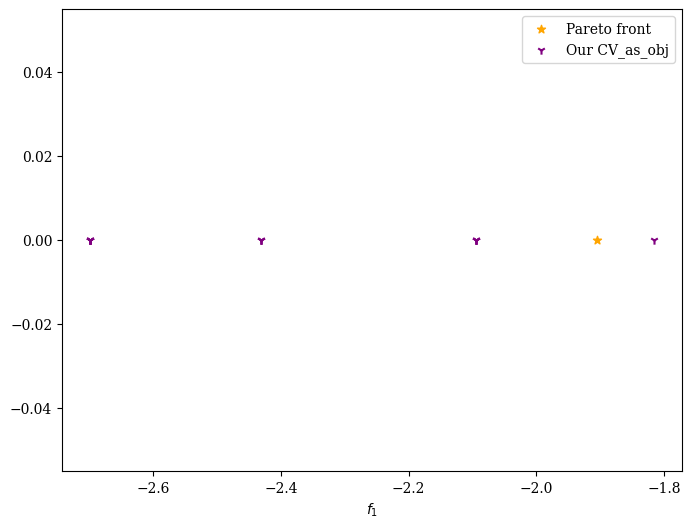

In [9]:
plot = Scatter()
plot.add(problem.pareto_front(), marker="*",
         color="orange", label='Pareto front')
# plot.add(res0.F, marker="x", color="red", label='Death penalty')
# plot.add(res1.F[:, :-1], marker="+", color="green", label='Baseline CV_as_obj')
# plot.add(res2.F[:, :-1], marker="1", color="blue", label='Our CV_as_obj')
plot.add(res3.F[:, :-1], marker="1", color="purple", label='Our CV_as_obj')
plot.show()

In [ ]:
problem.pareto_front()

In [ ]:
res0.F

In [ ]:
res3.F[res3.F[:, -1] <= 0.0000001]

In [ ]:
# from pymoo.core.evaluator import Evaluator
# from pymoo.core.individual import Individual

# cv = res4.F[:, 0]
# least_infeas = cv.argmin()
# x = res4.X[least_infeas]

# sol = Individual(X=x)
# Evaluator().eval(problem3, sol)

# print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (sol.X, sol.F, sol.CV))

In [ ]:
# res4.F[:,-2:].shape

In [ ]:
# plot = Scatter()
# plot.add(problem3.pareto_front(), marker="*", color="black", alpha=0.7, s=100)
# plot.add(res4.F[:,-2:], facecolor="none", edgecolor="red")
# plot.show()

In [ ]:
terminate_here

# Diversity Factor


In [ ]:
import numpy as np
from pymoo.core.problem import Problem
from pymoo.problems import get_problem
from scipy.spatial import cKDTree
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SimulatedBinaryCrossover as SBX
from pymoo.operators.mutation.pm import PolynomialMutation as PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.optimize import minimize
from pymoo.core.callback import Callback

In [ ]:
from annoy import AnnoyIndex


class DiversityEnhancedProblem(Problem):
    def __init__(self, problem, neighbors=5, trees=10):
        super().__init__(
            n_var=problem.n_var,
            n_obj=problem.n_obj + 1,
            n_constr=problem.n_constr,
            xl=problem.xl,
            xu=problem.xu,
        )
        self.base_problem = problem
        self.neighbors = neighbors
        self.population = []
        self.tree = AnnoyIndex(self.n_var, "manhattan")
        self.tree_cache = {}  # To store diversity values
        self.trees = trees  # Number of trees for Annoy

    def update_population(self, pop):
        self.population = pop.get("X")
        self.tree.unbuild()  # Clear the current tree
        for i, x in enumerate(self.population):
            self.tree.add_item(i, x.tolist())
        self.tree.build(self.trees)
        self.tree_cache = {}  # Clear cache after update

    def calculate_diversity(self, x):
        if len(self.population) > 1:
            distances = self.tree.get_nns_by_vector(
                x, self.neighbors, include_distances=True
            )[1]
            return 1.0 / np.mean(distances)
        return 0

    def _evaluate(self, x, out, *args, **kwargs):
        base_out = {}
        self.base_problem._evaluate(x, base_out, *args, **kwargs)
        f = base_out["F"]
        x = np.atleast_2d(x)

        # Calculate diversity, using cache if available
        diversity = np.array(
            [self.tree_cache.get(tuple(xi), self.calculate_diversity(xi)) for xi in x]
        )
        for xi, div in zip(x, diversity):
            self.tree_cache[tuple(xi)] = div  # Update cache

        out["F"] = np.column_stack([f, diversity])


class DiversityCallback(Callback):
    def __init__(self, problem):
        super().__init__()
        self.problem = problem

    def notify(self, algorithm):
        self.problem.update_population(algorithm.pop)


# Original problem from pymoo
original_problem = get_problem("zdt2")

# Enhanced problem with diversity objective
problem = DiversityEnhancedProblem(original_problem, neighbors=10)

# Setup the algorithm
algorithm = NSGA2(
    pop_size=100,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True,
)

# Execute the optimization
res1 = minimize(
    problem,
    algorithm,
    ("n_gen", 10000),
    verbose=True,
    seed=1,
    callback=DiversityCallback(problem),
)

res2 = minimize(
    original_problem,
    algorithm,
    ("n_gen", 2000),
    verbose=False,
    seed=0,
    # callback=DiversityCallback(problem)
)

In [ ]:
print(res1.F.shape, res2.F.shape)

In [ ]:
from visualization.scatter import Scatter

plot = Scatter()
plot.add(res1.F[:, :-1], facecolor="none", edgecolor="red")
plot.add(res2.F, facecolor="none", edgecolor="blue")
plot.show()

In [ ]:
from visualization.scatter import Scatter

plot = Scatter()
plot.add(res1.F, facecolor="none", edgecolor="red")
# plot.add(res2.F, facecolor="none", edgecolor="blue")
plot.show()

In [ ]:
from pymoo.factory import get_performance_indicator

# Assuming 'result' is the output of your optimization algorithm
hv = get_performance_indicator("hv", ref_point=np.array(
    [1.1, 1.1]))  # Adjust ref_point as needed
hypervolume = hv.calc(res1.F)

print("Hypervolume:", hypervolume)

In [ ]:
from visualization.scatter import Scatter
from annoy import AnnoyIndex
import numpy as np


class DiversityEnhancedProblem2(Problem):
    def __init__(self, problem, neighbors=5, trees=10, update_interval=5, change_threshold=0.2):
        super().__init__(n_var=problem.n_var,
                         n_obj=problem.n_obj + 1,
                         n_constr=problem.n_constr,
                         xl=problem.xl,
                         xu=problem.xu)
        self.base_problem = problem
        self.neighbors = neighbors
        self.population = []
        self.tree = AnnoyIndex(self.n_var, 'euclidean')
        self.trees = trees
        self.update_interval = update_interval
        self.change_threshold = change_threshold
        self.generation_count = 0
        self.last_population = None

    def update_population(self, pop):
        self.population = pop.get("X")
        self.generation_count += 1

        # Determine if the tree needs updating
        if self.last_population is None or self.generation_count % self.update_interval == 0 or self.population_has_changed():
            self.rebuild_tree()
            self.last_population = np.array(self.population.copy())
            print("Tree rebuilt.")

    def population_has_changed(self):
        """ Checks if significant changes have occurred in the population """
        if self.last_population is not None:
            dists = np.linalg.norm(
                self.last_population - self.population, axis=1)
            significant_changes = np.mean(dists > self.change_threshold)
            # More than 10% of the population has significantly changed
            return significant_changes > 0.1
        return False

    def rebuild_tree(self):
        """ Rebuilds the Annoy index """
        self.tree.unbuild()
        for i, x in enumerate(self.population):
            self.tree.add_item(i, x.tolist())
        self.tree.build(self.trees)

    def calculate_diversity(self, x):
        if len(self.population) > 1:
            distances = self.tree.get_nns_by_vector(
                x, self.neighbors, include_distances=True)[1]
            return 1.0 / np.mean(distances)
        return 0

    def _evaluate(self, x, out, *args, **kwargs):
        base_out = {}
        self.base_problem._evaluate(x, base_out, *args, **kwargs)
        f = base_out["F"]
        x = np.atleast_2d(x)

        # Calculate diversity
        diversity = np.array([self.calculate_diversity(xi) for xi in x])
        out["F"] = np.column_stack([f, diversity])


# Original problem from pymoo
original_problem = get_problem("zdt2")

# Enhanced problem with diversity objective
problem2 = DiversityEnhancedProblem2(original_problem, neighbors=10)

# Setup the algorithm
algorithm = NSGA2(
    pop_size=100,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

# Execute the optimization
res1 = minimize(
    problem2,
    algorithm,
    ('n_gen', 5000),
    verbose=True,
    seed=1,
    callback=DiversityCallback(problem)
)

res2 = minimize(
    original_problem,
    algorithm,
    ('n_gen', 2000),
    verbose=False,
    seed=0,
)


plot = Scatter()
plot.add(res1.F[:, 1:], facecolor="none", edgecolor="red")
plot.add(res2.F, facecolor="none", edgecolor="blue")
plot.show()

In [ ]:
from pymoo.core.problem import Problem
import numpy as np


class ConstraintAsObjectiveProblem(Problem):
    def __init__(self, problem):
        super().__init__(n_var=problem.n_var,
                         n_obj=problem.n_obj + problem.n_constr,
                         n_constr=0,  # No explicit constraints as they are now objectives
                         xl=problem.xl,
                         xu=problem.xu)
        self.problem = problem

    def _evaluate(self, x, out, *args, **kwargs):
        # Evaluate the original problem
        res = {}
        self.problem._evaluate(x, res)

        # Combine original objectives with constraints as new objectives
        f = res["F"]
        # Constraint violation for g(x) > 0
        g = np.where(res["G"] > 0, res["G"], 0)
        h = np.abs(res["H"])  # Absolute value for equality constraints

        # Combine into a single objective array
        out["F"] = np.column_stack([f, g, h])

In [ ]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.selection.tournament import compare
from pymoo.optimize import minimize
from pymoo.problems import get_problem


class FeasibilityFirstNSGA2(NSGA2):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def _next(self):
        # Overriding the selection process to prioritize feasibility
        def feasibility_first(a, b):
            # Check if either solution is feasible
            is_feasible_a = np.all(self.pop[a].get("F")[self.problem.n_obj :] <= 0)
            is_feasible_b = np.all(self.pop[b].get("F")[self.problem.n_obj :] <= 0)

            if is_feasible_a and not is_feasible_b:
                return a
            elif not is_feasible_a and is_feasible_b:
                return b
            else:
                # If both are feasible or infeasible, fall back to regular comparison
                return compare(
                    a, b, self.pop, self.n_survive, self.rank_key, self.crowding_key
                )

        # Tournament selection modified for feasibility
        mating_pool = self.selection(self.pop, self.n_offsprings, feasibility_first)
        off = self.crossover.do(self.problem, self.pop, mating_pool)
        off = self.mutation.do(self.problem, off)
        self.evaluator.eval(self.problem, off)
        self.pop = self.survival.do(
            self.problem, self.pop, off, n_survive=self.pop_size
        )


problem = get_problem("zdt1")
wrapped_problem = ConstraintAsObjectiveProblem(problem)

algorithm = FeasibilityFirstNSGA2(pop_size=100)

res = minimize(wrapped_problem, algorithm, ("n_gen", 100), verbose=True)